In [1]:
import sys
sys.path.append('../../lib/')

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
from jax.example_libraries.optimizers import adam, pack_optimizer_state
from hetero_simulation.archive.agent import ces_utility, log_utility
from hetero_simulation.ml.utils import *
from hetero_simulation.econ_models.krusell_smith import V_hat, opt_control, gamma_prime, prices, future, next_state, batch_loss
from hetero_simulation.econ_models.krusell_smith import zs, es, states, params0, config, n, mb, k, m, nn_shapes, generate_random_state

!export XLA_PYTHON_CLIENT_MEM_FRACTION=0.45

In [2]:
_, _, get_params = adam(step_size=0.1)
# params = pickle.load(open('../models/ks_model_5_47.pkl', 'rb'))
saved_state = pickle.load(open('../models/ks_model_5_final.pkl', 'rb'))
opt_state = pack_optimizer_state(saved_state)
params = get_params(opt_state)

Xs, Zs, Es = generate_random_state()
xs = Xs.reshape(-1, 1)

<AxesSubplot:xlabel='x', ylabel='g'>

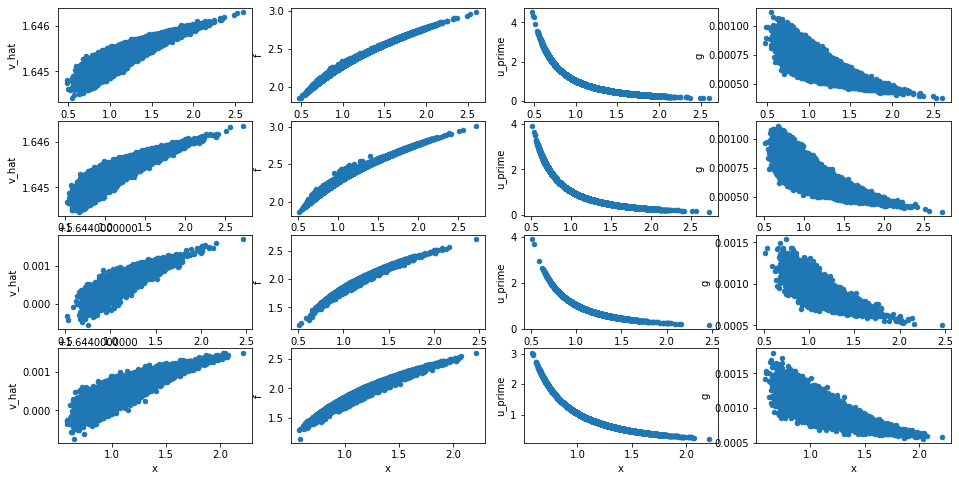

In [3]:
u = log_utility()
v_hats = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: V_hat(params0, X, Z, E[i], X[i]))(jnp.arange(k)))(Xs, Zs, Es)
c_stars = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: X[i] * opt_control(params0, X, Z, E[i], X[i]))(jnp.arange(k)))(Xs, Zs, Es)
f, g, X_prime = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: future(params0, config, X, Z, E, i))(jnp.arange(k)))(Xs, Zs, Es)
# g = jax.vmap(lambda g, c: -1 * (1 / (g - c)))(g.reshape(-1, 1), c_stars.reshape(-1, 1))
us = jax.vmap(jax.vmap(u))(c_stars)
u_primes = jax.vmap(jax.vmap(jax.grad(u)))(c_stars)

df = pd.DataFrame(jnp.concatenate([xs.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                   v_hats.reshape(-1, 1), X_prime.reshape(-1, 1), f.reshape(-1, 1), g.reshape(-1, 1),
                                   c_stars.reshape(-1, 1), us.reshape(-1, 1), u_primes.reshape(-1, 1)], axis=1))
df.columns = ['x', 'Z', 'e', 'v_hat', 'x_prime', 'f', 'g', 'c_star', 'u', 'u_prime']
fig, axes = plt.subplots(4, 4, figsize=(16, 8))
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='v_hat', kind='scatter', ax=axes.flatten()[0])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='f', kind='scatter', ax=axes.flatten()[1])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='u_prime', kind='scatter', ax=axes.flatten()[2])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', ax=axes.flatten()[3])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='v_hat', kind='scatter', ax=axes.flatten()[4])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='f', kind='scatter', ax=axes.flatten()[5])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='u_prime', kind='scatter', ax=axes.flatten()[6])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='g', kind='scatter', ax=axes.flatten()[7])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='v_hat', kind='scatter', ax=axes.flatten()[8])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='f', kind='scatter', ax=axes.flatten()[9])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='u_prime', kind='scatter', ax=axes.flatten()[10])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', ax=axes.flatten()[11])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='v_hat', kind='scatter', ax=axes.flatten()[12])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='f', kind='scatter', ax=axes.flatten()[13])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='u_prime', kind='scatter', ax=axes.flatten()[14])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='g', kind='scatter', ax=axes.flatten()[15])

<AxesSubplot:xlabel='x', ylabel='g'>

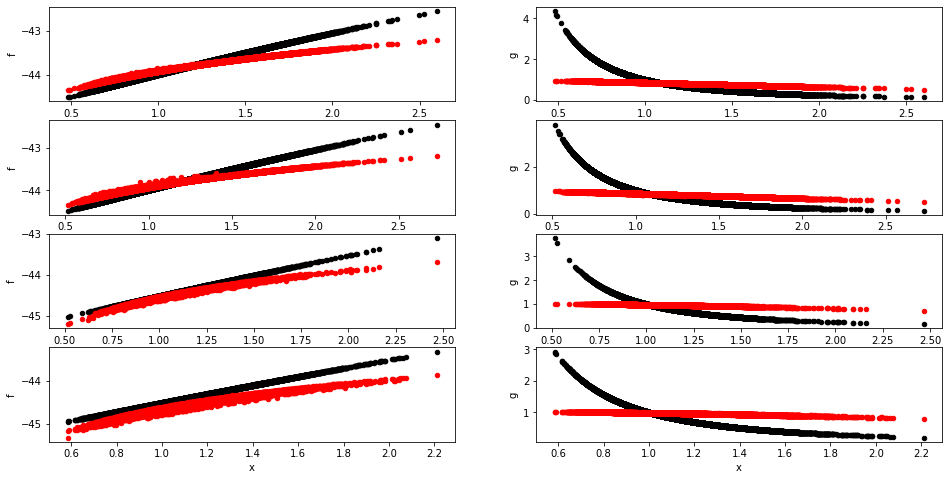

In [4]:
u = log_utility()
v_hats = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: V_hat(params, X, Z, E[i], X[i]))(jnp.arange(k)))(Xs, Zs, Es)
c_stars = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: X[i] * opt_control(params, X, Z, E[i], X[i]))(jnp.arange(k)))(Xs, Zs, Es)
f, g, X_prime = jax.vmap(lambda X, Z, E: jax.vmap(lambda i: future(params, config, X, Z, E, i))(jnp.arange(k)))(Xs, Zs, Es)
# g = jax.vmap(lambda g, c: -1 * (1 / (g - c)))(g.reshape(-1, 1), c_stars.reshape(-1, 1))
us = jax.vmap(jax.vmap(u))(c_stars)
u_primes = jax.vmap(jax.vmap(jax.grad(u)))(c_stars)

df = pd.DataFrame(jnp.concatenate([Xs.reshape(-1, 1), jnp.repeat(Zs, k).reshape(-1, 1), Es.reshape(-1, 1), 
                                   v_hats.reshape(-1, 1), X_prime.reshape(-1, 1), f.reshape(-1, 1), g.reshape(-1, 1),
                                   c_stars.reshape(-1, 1), us.reshape(-1, 1), u_primes.reshape(-1, 1)], axis=1))
df.columns = ['x', 'Z', 'e', 'v_hat', 'x_prime', 'f', 'g', 'c_star', 'u', 'u_prime']
fig, axes = plt.subplots(4, 2, figsize=(16, 8))
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='v_hat', kind='scatter', color='black', ax=axes.flatten()[0])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='f', kind='scatter', color='red', ax=axes.flatten()[0])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes.flatten()[1])
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', color='red', ax=axes.flatten()[1])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='v_hat', kind='scatter', color='black', ax=axes.flatten()[2])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='f', kind='scatter', color='red', ax=axes.flatten()[2])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes.flatten()[3])
df[(df['e'] == 1) & (df['Z'] == 0.99)].plot(x='x', y='g', kind='scatter', color='red', ax=axes.flatten()[3])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='v_hat', kind='scatter', color='black', ax=axes.flatten()[4])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='f', kind='scatter', color='red', ax=axes.flatten()[4])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes.flatten()[5])
df[(df['e'] == 0) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', color='red', ax=axes.flatten()[5])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='v_hat', kind='scatter', color='black', ax=axes.flatten()[6])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='f', kind='scatter', color='red', ax=axes.flatten()[6])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='u_prime', kind='scatter', color='black', ax=axes.flatten()[7])
df[(df['e'] == 0) & (df['Z'] == 0.99)].plot(x='x', y='g', kind='scatter', color='red', ax=axes.flatten()[7])

In [5]:
df['ex'] = df['x'].apply(lambda x: np.exp(x))
df['lnx'] = df['x'].apply(lambda x: np.log(x+1))
df['ex_prime'] = df['x'].apply(lambda x: 1/np.exp(x))
df['lnx_prime'] = df['x'].apply(lambda x: 1/np.log(x+1))

<AxesSubplot:xlabel='x', ylabel='lnx_prime'>

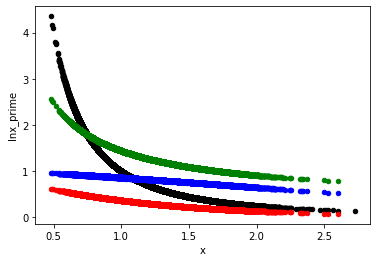

In [6]:
fig, ax = plt.subplots()
df[df['x'] > 0].plot(x='x', y='u_prime', kind='scatter', ax=ax, color='black')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='g', kind='scatter', ax=ax, color='blue')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='ex_prime', kind='scatter', ax=ax, color='red')
df[(df['e'] == 1) & (df['Z'] == 1.01)].plot(x='x', y='lnx_prime', kind='scatter', ax=ax, color='green')

<AxesSubplot:xlabel='x', ylabel='c_star'>

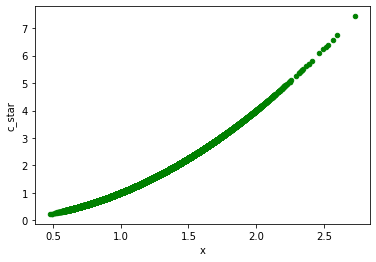

In [7]:
fig, ax = plt.subplots()
df.plot(x='x', y= 'c_star', kind='scatter', color='green', ax=ax)

In [8]:
Xsp = Xs.copy()
Zsp = Zs.copy()
Esp = Es.copy()

Xsp_mat = Xsp.reshape(1, n, k)
Zsp_mat = Zsp.reshape(1, n)
Esp_mat = Esp.reshape(1, n, k)

Xsp_bar = jnp.sum(Xsp, axis=1)[:, jnp.newaxis]
Zsp_bar = Zsp[:, jnp.newaxis]
Esp_bar = jnp.mean(Esp, axis=1)[:, jnp.newaxis]
key = jax.random.PRNGKey(np.random.randint(1, int(1e8)))

for i in range(100):
    keys = jax.random.split(key, n * k).reshape(n, k, 2)
    Xsp = jax.vmap(gamma_prime, in_axes=(None, 0, 0, 0))(params, Xsp, Zsp, Esp)
    Zsp, Esp = next_state(Zsp, Esp, keys)
    
    Xsp_mat = jnp.concatenate((Xsp_mat, Xsp.reshape(1, n, k)), axis=0)
    Zsp_mat = jnp.concatenate((Zsp_mat, Zsp.reshape(1, n)), axis=0)
    Esp_mat = jnp.concatenate((Esp_mat, Esp.reshape(1, n, k)), axis=0)

    Xsp_bar = jnp.concatenate((Xsp_bar, jnp.sum(Xsp, axis=1)[:, jnp.newaxis]), axis=1)
    Zsp_bar = jnp.concatenate((Zsp_bar, Zsp[:, jnp.newaxis]), axis=1)
    Esp_bar = jnp.concatenate((Esp_bar, jnp.mean(Esp, axis=1)[:, jnp.newaxis]), axis=1)
    key = keys[-1, -1]

In [9]:
Xs = Xsp_mat[10]
Zs = Zsp_mat[10]
Es = Esp_mat[10]

<AxesSubplot:>

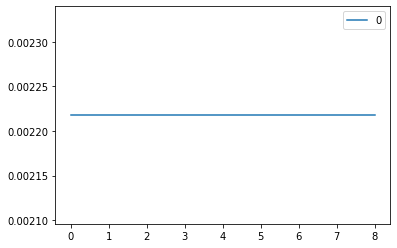

In [11]:
pd.DataFrame(Xsp_bar[1,1:10].T).plot(kind='line')

In [ ]:
i = 2
X = Xs[i]
Z = Zs[i]
e = Es[i, 0]
x = Xs[i, 0]

opt_control(params, X, Z, e, x)